# Is a bird?

<blockquote>This project was done in the first lesson by the instructor.</blockquote>

In [1]:
## Instructor used duckduckgo_search to search for image.
## But the latest version of duckduckgo_search throws error.
## Thus, we will be using fastbook instead.

!pip install -Uqq fastai fastbook

## Step 1: Downloading the image

<p>They used duckduckgo_search so their code had ddg_images.
We are gonna use fastbook so our code will be different.</p>

In [2]:
from fastbook import *
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")

    # This function will return links for number of images you provide in max_images.
    return search_images_ddg(term, max_images=max_images)

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
urls = search_images("bird photos", max_images=1)
urls[0]

Searching for 'bird photos'


'https://wallpapercave.com/wp/9UfwjXV.jpg'

...and then download the url and take a look at it.

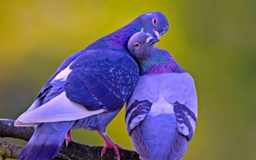

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Now, let's do the same for forest photos...

Searching for 'forest photos'


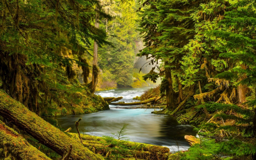

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    ## Checking and creating a path for both bird and forest
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)

    ## Downloading normal bird or forest photo
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) # Adding sleep so that it never gets overloaded.

    ## Downloading images of bird or forest with sun light in it.
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)

    ## Downloading images of bird or forest with shade in it.
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)

    ## Resize all images
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

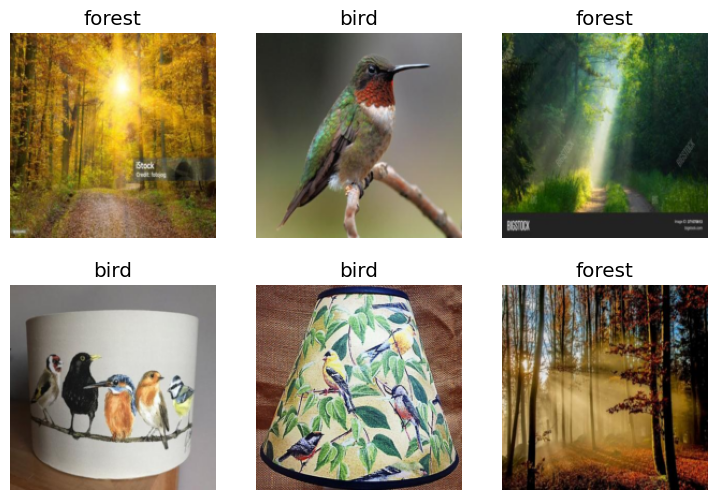

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

`_________________________________________________________________________________________________________________`

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/apoorvsingh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 35.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.776206,0.907008,0.303030,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.197673,0.110476,0.030303,00:04
1,0.172181,0.040755,0.000000,00:03
2,0.124803,0.019820,0.000000,00:03
3,0.090891,0.014683,0.000000,00:03
4,0.070315,0.011014,0.000000,00:03
5,0.057156,0.010969,0.000000,00:03
6,0.047269,0.010377,0.000000,00:03
7,0.039692,0.010855,0.000000,00:03
8,0.033997,0.011850,0.000000,00:03
9,0.029352,0.009935,0.000000,00:03


## Step 3: Use our model

In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999
